In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from gensim.models.coherencemodel import CoherenceModel
import spacy

In [2]:
text = pd.read_csv('/kaggle/input/airline/text_cleaning.csv')
text.rename(columns={'Review id': 'review_id',
                     'Review header': 'review_header'},
            inplace=True)
text.columns = text.columns.str.lower()
text.head()

,review_id,review_header,review,recommended,review_cleaned,review_bigrams,review_trigrams
0,anchor885571,"""very terrible experience""",i bought roundtrip and return tickets from _gp...,no,buy roundtrip return ticket _gpe_ _gpe_ via _g...,buy roundtrip return ticket _gpe_ _gpe_ via _g...,buy roundtrip return ticket _gpe_ _gpe_ via _g...
1,anchor881710,"""very concerned about the safety of Aeroflot""",i am shocked at how far aeroflot standards hav...,no,shock far aeroflot standard fall since invade ...,shock far aeroflot standard fall since invade ...,shock far aeroflot standard fall since invade ...
2,anchor767446,"""felt very rushed and unpolished""",aeroflot has set high standards of achieving a...,no,aeroflot set high standard achieve star airlin...,aeroflot set high standard achieve star airlin...,aeroflot set high standard achieve star airlin...
3,anchor758822,"""Best airline in Russia""",best airline in _gpe_ very nice staff comforta...,yes,best airline _gpe_ nice staff comfortable seat...,best airline _gpe_ nice staff comfortable seat...,best airline _gpe_ nice staff comfortable seat...
4,anchor754420,"""cabin crew were outstanding""",i was very impressed with the staff many thank...,yes,impress staff many thank aeroflot representati...,impress staff many thank aeroflot representati...,impress staff many thank aeroflot representati...


In [3]:
data = text['review_trigrams'].apply(lambda x: x.split())

In [4]:
def remove_1_char(text):
    new_text = []
    for w in text:
        if len(w) > 1:
            new_text.append(w)
            
    return new_text

data = data.apply(remove_1_char)
data

0        [buy, roundtrip, return, ticket, _gpe_, _gpe_,...
1        [shock, far, aeroflot, standard, fall, since, ...
2        [aeroflot, set, high, standard, achieve, star,...
3        [best, airline, _gpe_, nice, staff, comfortabl...
4        [impress, staff, many, thank, aeroflot, repres...
                               ...                        
57927    [terrible, experience, check, wife, _date_, fr...
57928    [one, good, low, cost, airline, need, make, su...
57929    [rynair, luxury, compare, wizz, air, charge, e...
57930    [go, ciampino, airport, _time_, early, try, op...
57931    [wizz, air, hand, bad, airline, area, customer...
Name: review_trigrams, Length: 57932, dtype: object

# LDA

In [5]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data)
id2word.filter_extremes(no_below=10, no_above=0.5)


# Create Corpus
texts = data

# Term Document Frequency
corpus = [id2word.doc2bow(t) for t in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 6), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 3), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 3), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 2), (42, 1), (43, 4), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 9), (54, 4), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1)]]


In [6]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim.utils.ClippedCorpus(corpus, int(len(corpus)*0.75)),
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           chunksize=200,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.61,
                                           per_word_topics=True)

In [7]:
print(lda_model.print_topics()[0])
doc_lda = lda_model[corpus]
doc_lda

(0, '0.073*"passenger" + 0.032*"crew" + 0.022*"staff" + 0.020*"cabin" + 0.013*"board" + 0.011*"make" + 0.010*"member" + 0.010*"grind" + 0.010*"aircraft" + 0.009*"jetstar"')


In [8]:
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_model_lda = CoherenceModel(model=lda_model, texts=data, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4842035159794235


# pyLDAvis

In [9]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
pyLDAvis.enable_notebook()
LDAvis_prepared =  pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.201322 -0.036595       1        1  12.238325
5     -0.153881 -0.059475       2        1  11.584337
8     -0.177301  0.061771       3        1  10.686159
3      0.209414 -0.019610       4        1   9.646288
10     0.123043 -0.025884       5        1   9.592301
6      0.001672 -0.223469       6        1   8.506860
9     -0.065766 -0.206226       7        1   8.260869
2     -0.130822  0.245461       8        1   6.848392
11     0.144520  0.109245       9        1   6.216883
7     -0.006924  0.027893      10        1   5.883702
0      0.037372  0.125196      11        1   5.725562
1      0.219995  0.001694      12        1   4.810321, topic_info=        Term          Freq         Total Category  logprob  loglift
239     seat  48117.000000  48117.000000  Default  30.0000  30.0000
11     check  27728.000000  27728.000000  Default  29.0000  29.0000
2038  qantas  23185.000000  23185.000000  Default  28.0000  28.0000
583    delay  26851.000000  26851.000000  Default  27.0000  27.0000
38       pay  23451.000000  23451.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
283      fly    807.556634  37779.319019  Topic12  -5.3900  -0.8111
1192    name    495.425808   1983.811142  Topic12  -5.8786   1.6470
150     full    561.146413   5158.432932  Topic12  -5.7540   0.8160
177      one    576.302289  21239.732437  Topic12  -5.7274  -0.5726
678    point    520.204443   4226.282764  Topic12  -5.8298   0.9396

[789 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.610483  _date_
0         2  0.062459  _date_
0         3  0.088315  _date_
0         4  0.000167  _date_
0         5  0.081145  _date_
...     ...       ...     ...
1031      8  0.001061   young
1031      9  0.002122   young
1031     10  0.002122   young
1031     11  0.091259   young
1031     12  0.001061   young

[7572 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 6, 9, 4, 11, 7, 10, 3, 12, 8, 1, 2])

## Visualize topics-Wordcloud of Top N words in each topic



In [11]:
# wordcloud of Top N words in each topic
import wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
cols = cols*2

cloud = WordCloud(background_color= 'white',
                  width=2500,
                  height=2800,
                  max_words=30,
                #   colormap= 'tab20c',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False, num_words=20, num_topics=12)

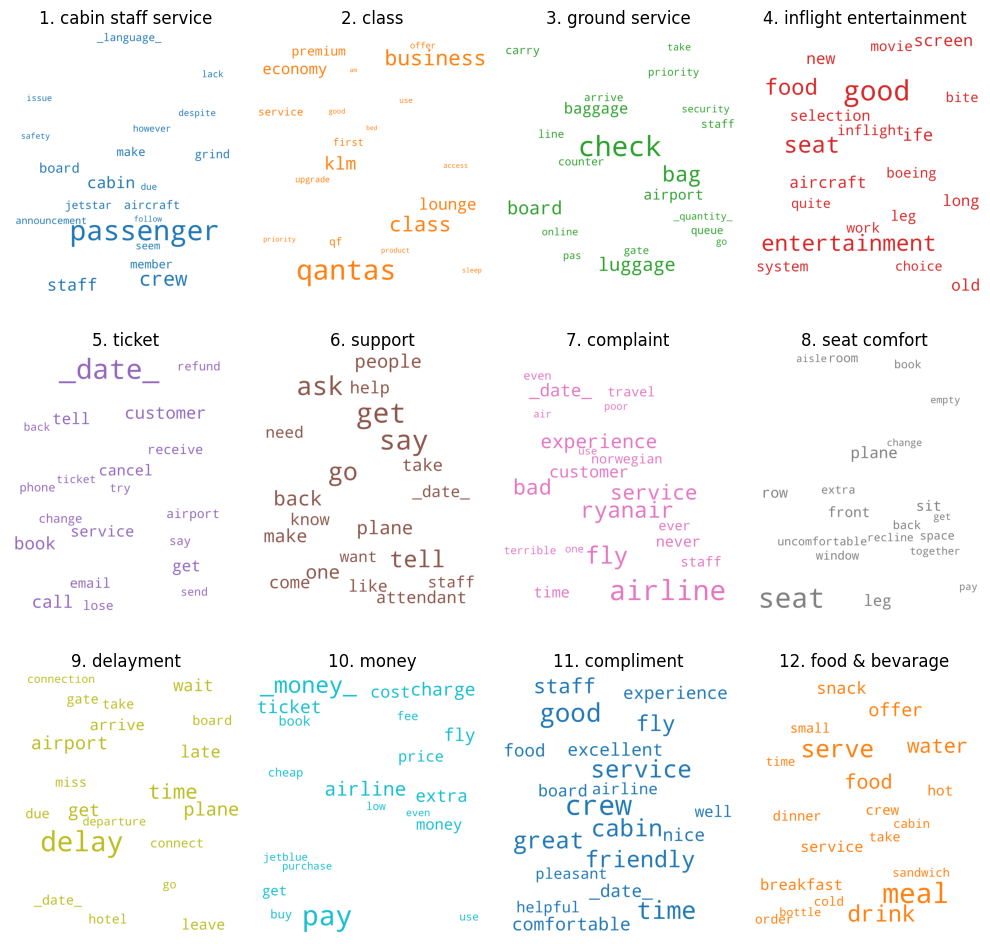

In [15]:
fig, axes = plt.subplots(3, 4, figsize=(10,10), sharex=True, sharey=True)

labels = ['cabin staff service', 'class', 'ground service', 'inflight entertainment', 'ticket', 
          'support', 'complaint', 'seat comfort', 'delayment', 'money', 'compliment', 'food & bevarage']
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title(str(i+1) + '. ' + labels[i], fontdict=dict(size=12))
    plt.gca().axis('off')
                                        
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis( 'off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Topic of each review

In [13]:
def get_topic(bow):
    lst_topics = lda_model.get_document_topics(bow)
    return max(lst_topics, key=lambda x: x[1])[0]

In [14]:
review_df = pd.DataFrame({'review': text.review, 'word': data, 'bow': corpus})
review_df['topic_num'] = review_df.bow.apply(get_topic)
review_df['topic'] = review_df['topic_num'].apply(lambda x: labels[x-1])
review_df

,review,word,bow,topic_num,topic
0,i bought roundtrip and return tickets from _gp...,"[buy, roundtrip, return, ticket, _gpe_, _gpe_,...","[(0, 1), (1, 1), (2, 6), (3, 1), (4, 2), (5, 1...",4,inflight entertainment
1,i am shocked at how far aeroflot standards hav...,"[shock, far, aeroflot, standard, fall, since, ...","[(0, 1), (2, 4), (6, 1), (43, 1), (46, 1), (47...",6,support
2,aeroflot has set high standards of achieving a...,"[aeroflot, set, high, standard, achieve, star,...","[(2, 5), (38, 2), (47, 3), (50, 1), (66, 3), (...",1,cabin staff service
3,best airline in _gpe_ very nice staff comforta...,"[best, airline, _gpe_, nice, staff, comfortabl...","[(13, 1), (47, 3), (66, 1), (81, 1), (86, 2), ...",10,money
4,i was very impressed with the staff many thank...,"[impress, staff, many, thank, aeroflot, repres...","[(2, 1), (3, 1), (71, 1), (110, 1), (133, 1), ...",10,money
...,...,...,...,...,...
57927,had a terrible experience at check in my wife ...,"[terrible, experience, check, wife, _date_, fr...","[(0, 1), (11, 1), (21, 1), (29, 1), (38, 1), (...",6,support
57928,one of the better low cost airlines but you ne...,"[one, good, low, cost, airline, need, make, su...","[(0, 1), (6, 1), (7, 1), (8, 1), (11, 1), (16,...",3,ground service
57929,rynair is a luxury comparing to wizz air they ...,"[rynair, luxury, compare, wizz, air, charge, e...","[(38, 1), (46, 1), (54, 1), (57, 1), (64, 1), ...",6,support
57930,we went to ciampino airport _time_ early and t...,"[go, ciampino, airport, _time_, early, try, op...","[(7, 2), (26, 1), (38, 1), (46, 1), (56, 1), (...",2,class
